In [7]:
from keras.datasets import mnist
import numpy as np
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(np.shape(X_train))
print(np.shape(y_train))
print(y_train[0])

(60000, 28, 28)
(60000,)
5


In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras
from keras import layers
c

latent_dim = 100
height = 32
width = 32
channels = 3

#最適化アルゴリズム
#学習を安定させるために重みをclip＆weight decayを用いる
#識別者の学習ではRMSpropを用いたほうが良いとする事例もある
#またlrを非常に小さくする(0.00005以下)場合もある
#rmsp = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
#識別者用＆敵対者用(DCGAN論文では両方Adam)
adam = keras.optimizers.Adam(lr=0.0002, beta_1=0.5, clipvalue=1.0, decay=1e-8)

#DC論文ではすべての重みを以下で初期化している
init = keras.initializers.RandomNormal(stddev=0.02)

Using plaidml.keras.backend backend.
INFO:plaidml:Opening device "metal_amd_radeon_pro_5300m.0"


In [2]:
#生成ネットワーク
generator_input = keras.Input(shape=(latent_dim,))

#潜在変数を4x4 1024-channels 特徴マップへ変換
x = layers.Dense(1024 * 4 * 4,kernel_initializer=init)(generator_input)
#この実装では生成ネットワークの活性化関数にLeakyReLUを用いるが
#代わりに以下のBatchNormalization＋LeRUを使う場合もある
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
#x = layers.LeakyReLU(0.2)(x)
x = layers.Reshape((4, 4, 1024))(x)

#4x4 1024-channelsを8x8 512-channelsの特徴マップへDeconvolutionで変換
#ストライドサイズで割り切れるカーネルサイズを使う
x = layers.Conv2DTranspose(512, 8, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
#x = layers.LeakyReLU(0.2)(x)

#8x8 512-channelsを16x16 256-channelsの特徴マップへDeconvolutionで変換
#ストライドサイズで割り切れるカーネルサイズを使う
x = layers.Conv2DTranspose(256, 16, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
#x = layers.LeakyReLU(0.2)(x)

#16x16 256-channelsを32x32 128-channelsの特徴マップへDeconvolutionで変換
#ストライドサイズで割り切れるカーネルサイズを使う
x = layers.Conv2DTranspose(128, 32, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
#x = layers.LeakyReLU(0.2)(x)

#32x32 128-channelsを３２x32 3-channelsの特徴マップへ変換
#最後の出力の活性化関数はtanhを使う
x = layers.Conv2D(channels, 5, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16384)             65536     
_________________________________________________________________
activation_1 (Activation)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 512)         33554944  
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 512)         2048      
__________

In [3]:
#識別ネットワーク
#LeakyReLU、Dropout、GlobalAveragedPoolingを使うのがポイント
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(64, 5, strides=2,padding='same',kernel_initializer=init)(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, 5, strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, 5, strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()


discriminator_optimizer  = adam
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 128)         0         
__________

In [4]:
#敵対的ネットワーク

#識別ネットワークの学習を止めて
discriminator.trainable = False
#生成ネットワークの学習をする
gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = adam 
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [6]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
from keras.preprocessing import image
from keras.datasets import cifar10
from tqdm import tqdm

#cifar10のダウンロード
(x_train, _), (x_test, y_test) = cifar10.load_data()

#各ピクセルが[0,1]の値を取るように正規化
#x_train = x_train.astype('float32') / 255.
#x_train = x_train.reshape(x_train.shape + (1,))
#x_test = x_test.astype('float32') / 255.
#x_test = x_test.reshape(x_test.shape + (1,))

#生成者の出力をtanhとしたので
#各ピクセルが[-1,1]の値を取るように正規化
x_train = (x_train.astype('float32')-127.5)/ 127.5
#x_train = x_train.reshape(x_train.shape + (1,))
x_test = (x_test.astype('float32')-127.5)/ 127.5
x_test = x_test.reshape(x_test.shape + (1,))

#DCGAN論文で使われているバッチ数を使う
batch_size = 128


epochs=10
batchSize=batch_size
batchCount = x_train.shape[0] / batchSize
print ('Epochs:', epochs)
print ('Batch size:', batchSize)
print ('Batches per epoch:', batchCount)

# 学習のループ
for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15) 
    #tqdmを使うとプログレスバーが出るがColabだと不安定なので別で代用する
    #for _ in tqdm(range(int(batchCount))): 
    for i in range(int(batchCount)):
        print("\r{0}% [{1}]".format(int(i/(batchCount-1)*100), "*" * int((i+1)/batchCount*50)), end="")
        # 潜在空間からランダムにサンプリング
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

        # データを生成する
        generated_images = generator.predict(random_latent_vectors)

        # 観測データと生成データを識別するための入力データをつくる
        real_images = x_train[np.random.randint(0, x_train.shape[0], size=batchSize)]
        combined_images = np.concatenate([generated_images, real_images])

        # 観測データ(0)と生成データ(1)を識別するラベルをつくる
        labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
        
        # ランダムなノイズを加える
        # ラベルを1ではなく0.7-1.2, 0を0-0.3のようなソフトラベルにすることもある
        #labels += 0.05 * np.random.random(labels.shape)
        labels *= 0.9


        #識別ネットワークの学習
        d_loss = discriminator.train_on_batch(combined_images, labels)

        #潜在空間からサンプリング
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

        # すべてリアルなデータだと騙すためのラベル(y=0)を生成
        misleading_targets = np.zeros((batch_size, 1))

        # 生成ネットワークの学習
        # min -y*log(D(G(z)))
        a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
        if i==int(batchCount)-1 :
            print("\n") 
            print('discriminator loss: %s' % (d_loss))
            print('adversarial loss  : %s' % (a_loss))
        
      

170500096/170498071 [==============================] - 31s 0us/step
Epochs: 10
Batch size: 128
Batches per epoch: 390.625
--------------- Epoch 1 ---------------
0% []

/Users/ryosuke/anaconda3/envs/kerasenv/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
INFO:plaidml:Analyzing Ops: 306 of 820 operations complete


99% [*************************************************]

discriminator loss: 11.1332245
adversarial loss  : 11.45859
--------------- Epoch 2 ---------------
99% [*************************************************]

discriminator loss: 11.050364
adversarial loss  : 11.33404
--------------- Epoch 3 ---------------
26% [*************]

KeyboardInterrupt: 

[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 ...

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]
  ...
  [nan nan nan]
  [nan nan nan]
  [nan nan nan]]]


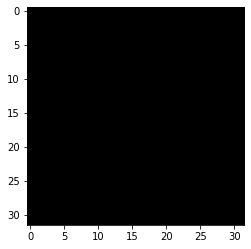

In [6]:
import matplotlib.pyplot as plt

#表示するサンプル数
examples=100
#潜在空間からサンプリング
noise = np.random.normal(0, 1, size=[examples, latent_dim])
#画像を生成
generatedImages = generator.predict(noise)

c = (generatedImages - np.min(generatedImages))/np.ptp(generatedImages)
print(c[8])
plt.imshow(c[8].reshape(height, width, channels), interpolation='nearest')

In [27]:
import matplotlib.pyplot as plt

#表示するサンプル数
examples=100
#潜在空間からサンプリング
noise = np.random.normal(0, 1, size=[examples, latent_dim])
#画像を生成
generatedImages = generator.predict(noise)

c = (generatedImages - np.min(generatedImages))/np.ptp(generatedImages)

dim=(10, 10)
plt.figure(figsize=(10, 10))
for i in range(c.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(c[i].reshape(height, width, channels), interpolation='nearest', cmap='gray', vmax=1, vmin=0)
    plt.axis('off')
plt.tight_layout()